C:\Users\bgpa4\AppData\Local\Temp\ipykernel_19888\1689382256.py:66: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


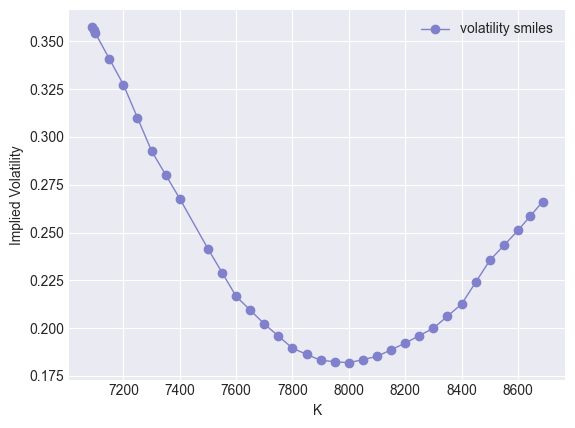

C:\Users\bgpa4\AppData\Local\Temp\ipykernel_19888\1689382256.py:79: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


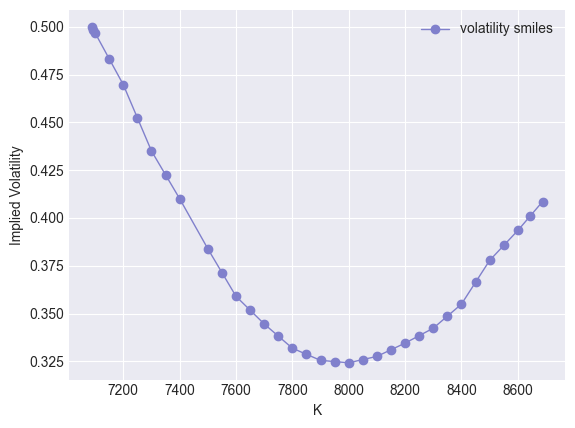

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os 
def Slope(X, Y, axis=1):
    sorted_idx = np.argsort(X, axis=axis)
    X = np.take_along_axis(X, sorted_idx, axis=axis)
    Y = np.take_along_axis(Y, sorted_idx, axis=axis)
    if axis==1:
        delta_X = X[:,1:] - X[:,:-1]
        delta_Y = Y[:,1:] - Y[:,:-1]
    if axis==0:
        delta_X = X[1:] - X[:-1]
        delta_Y = Y[1:] - Y[:-1]
    return delta_Y / delta_X

def recovery_curve(x, slope, y0=0.5):
    delta_x = x[1:] - x[:-1]
    delta_y = delta_x*slope
    y = np.array([delta_y[:i].sum() for i in range(1, len(x), 1)]) + y0
    y = np.hstack((np.array([y0]), y))
    return y


IVdir = 'ITMIV'
OCRange = 1
lower_range = 800
upper_range = 800

top_path = './../../../'

ForecastPath = top_path + 'Data/Forecast/'

file = top_path + 'Data/Interpolate/{}/{}/{}_{}.csv'.format(IVdir, OCRange, lower_range, upper_range)
if IVdir not in os.listdir(ForecastPath):
    os.mkdir(ForecastPath + '{}'.format(IVdir))

if str(OCRange) not in os.listdir(ForecastPath + '{}'.format(IVdir)):
    os.mkdir(ForecastPath + '{}/{}'.format(IVdir, OCRange))

if '{}_{}'.format(lower_range, upper_range) not in \
os.listdir(ForecastPath + '{}/{}'.format(IVdir, OCRange)):
    os.mkdir(ForecastPath + '{}/{}/{}_{}'.format(IVdir, OCRange, lower_range, upper_range))
output_dir_path = ForecastPath + '{}/{}/{}_{}/'.format(IVdir, OCRange, lower_range, upper_range)

IV_data = pd.read_csv(file, encoding='Big5', index_col=False)



IV_matrix = np.array(IV_data)
K_num = len(np.where(IV_matrix[0,0] == IV_matrix)[0])
K_closing = np.array(IV_data['履約價(收盤價)'])
K_closing = np.reshape(K_closing, (-1, K_num))
IV_closing = np.array(IV_data['隱含波動率(收盤價)'])
IV_closing = np.reshape(IV_closing, (-1, K_num))
K_IVslope_closing = Slope(X=K_closing, Y=IV_closing, axis=1)

K_settlement = np.array(IV_data['履約價(結算價)'])
K_settlement = np.reshape(K_settlement, (-1, K_num))
IV_settlement = np.array(IV_data['隱含波動率(結算價)'])
IV_settlement = np.reshape(IV_settlement, (-1, K_num))
K_IVslope_settlement = Slope(X=K_settlement, Y=IV_settlement, axis=1)


k = 20
plt.style.use('seaborn-darkgrid')
plt.plot(K_settlement[k], IV_settlement[k], lw=1, ls='-', marker='o', c=[0.5, 0.5, 0.8], label='volatility smiles')
#plt.plot([Udata[k,4]]*2, [Kmin, Kmax], lw=1, ls='--', c=[0.8, 0.5, 0.5], label='futures price')
plt.xlabel('K')
plt.ylabel('Implied Volatility')
plt.legend()
plt.show()

#x = np.arange(1, K_num+1, 1)
#y_right = 0.2
#y = np.array([K_IVslope[k,:i].sum() for i in range(1, K_num, 1)]) + y_right
#y = np.hstack((np.array([y_right]), y))
y = recovery_curve(K_settlement[k], K_IVslope_settlement[k])
plt.style.use('seaborn-darkgrid')
plt.plot(K_settlement[k], y, lw=1, ls='-', marker='o', c=[0.5, 0.5, 0.8], label='volatility smiles')
#plt.plot([Udata[k,4]]*2, [Kmin, Kmax], lw=1, ls='--', c=[0.8, 0.5, 0.5], label='futures price')
plt.xlabel('K')
plt.ylabel('Implied Volatility')
plt.legend()
plt.show()

若$X=[x_1, x_2,\dots x_n     ]$  
則 $TimeSeriesData(X, 30)= [[x_1, x_2,\dots x_{30}],\quad [x_2, x_3,\dots x_{31}]\dots [x_{n-30}, x_{n-29},\dots x_{n-1}]],\quad [x_{31}, x_{32},\dots x_n     ]$  

In [11]:
def TimeSeriesData(X, seq_length):
    X_train = np.zeros((len(X)-seq_length, seq_length, len(X[0])))
    y_train = np.zeros((len(X)-seq_length, len(X[0])))
    for i in range(len(X) - seq_length):
        X_train[i] = X[i:i+seq_length]
        y_train[i] = (X[i+seq_length])
    return np.array(X_train), np.array(y_train)
seq_length = 3
magnification_slope = 10000
IV_matrix_forecast = IV_matrix[seq_length*K_num:]
#收盤價
Inputs_closing_slope, Ouputs_closing = TimeSeriesData(K_IVslope_closing*magnification_slope, seq_length=seq_length)
columns_names_OHLC = ['期貨開盤價', '期貨最高價', '期貨最低價', '期貨收盤價']
column_index_OHLC = [IV_data.columns.get_loc(col) for col in columns_names_OHLC]
Inputs_OHLC = IV_matrix[range(0, len(IV_matrix), K_num)]
Inputs_OHLC = Inputs_OHLC[:,column_index_OHLC]
Inputs_OHLC = np.array([Inputs_OHLC[i:i+seq_length+1] for i in range(len(Inputs_OHLC)-seq_length)])
Inputs_OHLC = Inputs_OHLC.astype(float)

train_size = int(len(Inputs_closing_slope)*0.8)
X_train_closing = Inputs_closing_slope[:train_size]
OHLC_train = Inputs_OHLC[:train_size]
y_train_closing = Ouputs_closing[:train_size]
X_test_closing = Inputs_closing_slope[train_size:]
y_test_closing = Ouputs_closing[train_size:]
IV_matrix_test = IV_matrix_forecast[K_num*train_size:]
OHLC_test = Inputs_OHLC[train_size:]


#結算價
Inputs_settlement, Ouputs_settlement = TimeSeriesData(K_IVslope_settlement*magnification_slope, seq_length=seq_length)
train_size = int(len(Inputs_settlement)*0.8)
X_train_settlement = Inputs_settlement[:train_size]
y_train_settlement = Ouputs_settlement[:train_size]
X_test_settlement = Inputs_settlement[train_size:]
y_test_settlement = Ouputs_settlement[train_size:]


In [12]:
from keras.models import Model
from keras.layers import Input, Dense, LSTM, concatenate
from keras.optimizers import Adam

# 定義第一個ANN模型
input_lstm_OHLC = Input(shape=OHLC_train.shape[1:])
hidden1_OHLC = LSTM(100, return_sequences=True, activation='relu')(input_lstm_OHLC)
hidden2_OHLC = LSTM(100, activation='relu')(hidden1_OHLC)
output_OHLC = Dense(100)(hidden2_OHLC)

# 定義第二個LSTM模型
input_lstm_slope = Input(shape=X_train_settlement.shape[1:])
#lstm1 = LSTM(200, return_sequences=True, activation='relu')(input_slope)
hidden1_slope = LSTM(100, activation='relu')(input_lstm_slope)
output_slope = Dense(100)(hidden1_slope)

# 合併兩個模型的輸出
#merged = concatenate([output_ann, dense_lstm], axis=-1)
merged = concatenate([output_OHLC, output_slope], axis=-1)

# 加入一個Dense層
dense1 = Dense(100, activation='relu')(merged)
dense2 = Dense(100, activation='relu')(dense1)
# 最終輸出層
output = Dense(y_train_closing.shape[1])(dense2)

# 定義模型
model = Model(inputs=[input_lstm_OHLC, input_lstm_slope], outputs=output)

# 編譯模型
#adam = Adam(learning_rate=0.1)

model.compile(loss='mse', optimizer='adam', metrics=['mse'])

# 顯示模型結構
#model.summary()



# 訓練模型
model.fit([OHLC_train, X_train_settlement], y_train_settlement, epochs=50, \
          batch_size=3000, validation_split=0.2)

Epoch 1/50
1/1 [==============================] - 3s 3s/step - loss: 36266.6914 - mse: 36266.6914 - val_loss: 31817.2461 - val_mse: 31817.2461
Epoch 2/50
1/1 [==============================] - 0s 88ms/step - loss: 14496.1553 - mse: 14496.1553 - val_loss: 14834.1445 - val_mse: 14834.1445
Epoch 3/50
1/1 [==============================] - 0s 89ms/step - loss: 6792.2886 - mse: 6792.2886 - val_loss: 8120.0703 - val_mse: 8120.0703
Epoch 4/50
1/1 [==============================] - 0s 87ms/step - loss: 3751.2507 - mse: 3751.2507 - val_loss: 10591.7783 - val_mse: 10591.7783
Epoch 5/50
1/1 [==============================] - 0s 87ms/step - loss: 4051.3687 - mse: 4051.3687 - val_loss: 36374.5859 - val_mse: 36374.5859
Epoch 6/50
1/1 [==============================] - 0s 94ms/step - loss: 18715.7520 - mse: 18715.7520 - val_loss: 14618.5527 - val_mse: 14618.5527
Epoch 7/50
1/1 [==============================] - 0s 96ms/step - loss: 7170.8193 - mse: 7170.8193 - val_loss: 4474.1074 - val_mse: 4474.1074

In [13]:
model.fit([OHLC_train, X_train_settlement], y_train_settlement, epochs=100, batch_size=3000, validation_split=0.2)

Epoch 1/100


1/1 [==============================] - 0s 123ms/step - loss: 71.4328 - mse: 71.4328 - val_loss: 216.3657 - val_mse: 216.3657
Epoch 2/100
1/1 [==============================] - 0s 82ms/step - loss: 58.2711 - mse: 58.2711 - val_loss: 203.9044 - val_mse: 203.9044
Epoch 3/100
1/1 [==============================] - 0s 94ms/step - loss: 45.7051 - mse: 45.7051 - val_loss: 201.8101 - val_mse: 201.8101
Epoch 4/100
1/1 [==============================] - 0s 88ms/step - loss: 47.9708 - mse: 47.9708 - val_loss: 177.4950 - val_mse: 177.4950
Epoch 5/100
1/1 [==============================] - 0s 97ms/step - loss: 38.7015 - mse: 38.7015 - val_loss: 175.9986 - val_mse: 175.9986
Epoch 6/100
1/1 [==============================] - 0s 154ms/step - loss: 39.1585 - mse: 39.1585 - val_loss: 163.7177 - val_mse: 163.7177
Epoch 7/100
1/1 [==============================] - 0s 91ms/step - loss: 34.5282 - mse: 34.5282 - val_loss: 143.5479 - val_mse: 143.5479
Epoch 8/100
1/1 [==============================] - 0s 102m

In [14]:
test_loss = model.evaluate([OHLC_test, X_test_settlement], y_test_settlement)
print("Test Loss:", test_loss)

# 查看測試輸出
y_pred_settlement = model.predict([OHLC_test, X_test_settlement])



18/18 [==============================] - 0s 3ms/step - loss: 1.5680 - mse: 1.5680
Test Loss: [1.5679835081100464, 1.5679835081100464]
18/18 [==============================] - 0s 2ms/step


In [15]:
columns_names = ['履約價(收盤價)', '履約價(結算價)', '隱含波動率(收盤價)', '隱含波動率(結算價)']
column_index = [IV_data.columns.get_loc(col) for col in columns_names]
ForecastIV = np.zeros(((len(y_pred_settlement), K_num)))



for i in range(len(y_pred_settlement)):
    x = IV_matrix_test[i*K_num:(i+1)*K_num, column_index[1]]
    v0 = IV_matrix_test[i*K_num, column_index[3]]
    ForecastIV[i] = recovery_curve(x, y_pred_settlement[i]/(magnification_slope), y0=v0)
ForecastIV = np.reshape(ForecastIV,(-1,1))
Forecast_matrix  = np.hstack((IV_matrix_test, ForecastIV))
column = np.hstack((IV_data.columns.to_numpy(), np.array(['預測隱含波動率(結算價)'])))
Forecast_Data = pd.DataFrame(data=Forecast_matrix, columns=column)


Forecast_Data.to_csv(output_dir_path + 'sOHLC01.csv', index=False, encoding='Big5')